In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import confusion_matrix
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS
from linearmodels import PooledOLS, PanelOLS, RandomEffects
#Pentru normalitate
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import shapiro 
from scipy.stats import kstest, norm
#Pentru Homoschedasticitate
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
#Pentru multicolinaritate
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [18]:
panel_df = pd.read_csv("World-happiness-report-updated_2024.csv",encoding='unicode_escape')

panel_df.rename(columns={
    'Log GDP per capita':'GDP_capita_logged',
    'Perceptions of corruption':'Coruption',
    'Healthy life expectancy at birth':'Life_expectancy_at_birth',
    'Social support':'Social_support',
    'Regional indicator':'Region',
    'Freedom to make life choices':'Freedom',
    'Life Ladder':'happy'
},inplace=True)
panel_df["Financial Crisis"] = 0
panel_df["Covid"] = 0
panel_df.loc[panel_df['year']==2008,'Financial Crisis'] = 1
panel_df.loc[panel_df['year']==2020,'Covid'] =1 
panel_df['Crisis'] = panel_df['Financial Crisis'] + panel_df['Covid']
panel_df.set_index(["Country name","year"],inplace=True)
panel_df = panel_df.dropna(subset=['happy', 'GDP_capita_logged', 'Social_support', 'Freedom', 'Coruption'])
print(f"\nRows after cleaning: {len(panel_df)}")


Rows after cleaning: 2190


In [4]:
panel_df.head()


happy  GDP_capita_logged  Social_support  \
Country name year                                             
Afghanistan  2008  3.724              7.350           0.451   
             2009  4.402              7.509           0.552   
             2010  4.758              7.614           0.539   
             2011  3.832              7.581           0.521   
             2012  3.783              7.661           0.521   

                   Life_expectancy_at_birth  Freedom  Generosity  Coruption  \
Country name year                                                             
Afghanistan  2008                      50.5    0.718       0.164      0.882   
             2009                      50.8    0.679       0.187      0.850   
             2010                      51.1    0.600       0.118      0.707   
             2011                      51.4    0.496       0.160      0.731   
             2012                      51.7    0.531       0.234      0.776   

                   Positive affect  Negative affect  Financial Crisis  Covid  
Country name year                                                             
Afghanistan  2008            0.414            0.258                 1      0  
             2009            0.481            0.237                 0      0  
             2010            0.517            0.275                 0      0  
             2011            0.480            0.267                 0      0  
             2012            0.614            0.268                 0      0

In [5]:
# !pip install linearmodels

In [36]:
variabile_model = ['GDP_capita_logged','Social_support','Freedom','Coruption']
X = panel_df[variabile_model]
y = panel_df['happy']
X = sm.add_constant(X)

In [20]:
model_efecte_random = RandomEffects(y,X).fit(cov_type='clustered')
model_panel = PooledOLS(y,X).fit(cov_type='clustered',cluster_entity=True)

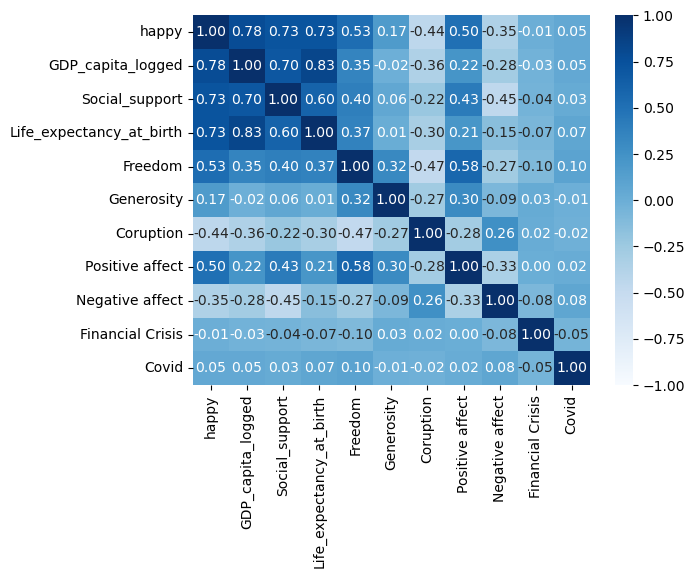

In [8]:
corr = panel_df.corr()
sns.heatmap(corr, annot=True,fmt='.2f',vmax=1,vmin=-1,cmap='Blues')
plt.show()

In [32]:
from scipy import stats
# 1. Fit Pooled OLS
pooled = PooledOLS(y, X).fit()

# 2. Calculate Breusch-Pagan LM Test
# Get residuals
resids = pooled.resids
n = y.index.levels[0].size  # Number of entities
t = y.index.levels[1].size  # Number of time periods

# Group residuals by entity and sum them
# Note: Ensure your index is (entity, time)
grouped_resids = resids.groupby(level=0).sum()
lm_stat = (n * t) / (2 * (t - 1)) * (np.sum(grouped_resids**2) / np.sum(resids**2) - 1)**2
p_value = stats.chi2.sf(lm_stat, 1)

print(f"BP LM Statistic: {lm_stat:.4f}")
print(f"p-value: {p_value:.4f}")

BP LM Statistic: 6057.4771
p-value: 0.0000


In [10]:
def hausman_test(fe_model, re_model):
    # Extract coefficients (b) and covariance matrices (v)
    # We only compare coefficients that exist in both models (usually excluding the constant)
    common_coefs = [v for v in fe_model.params.index if v in re_model.params.index]
    
    b_fe = fe_model.params[common_coefs]
    b_re = re_model.params[common_coefs]
    v_fe = fe_model.cov.loc[common_coefs, common_coefs]
    v_re = re_model.cov.loc[common_coefs, common_coefs]
    
    # Calculate the test statistic: (b_fe - b_re)' * inv(v_fe - v_re) * (b_fe - b_re)
    diff = b_fe - b_re
    cov_diff = v_fe - v_re
    
    # Use the Moore-Penrose pseudo-inverse for better numerical stability
    precision = np.linalg.pinv(cov_diff)
    chi2 = diff.T @ precision @ diff
    
    # Degrees of freedom = number of coefficients compared
    df = len(common_coefs)
    p_val = stats.chi2.sf(chi2, df)
    
    return chi2, df, p_val

In [33]:
fe = PanelOLS(y,X,entity_effects=True,time_effects=False).fit()
re = RandomEffects(y,X).fit()
chi2, df, p_values = hausman_test(fe,re)
print(fe.f_pooled)
print(p_values) # p-value = 0.65, deci modelul cu efecte fixe este superior modelului cu efecte random

Pooled F-statistic
H0: Effects are zero
Statistic: 20.8378
P-value: 0.0000
Distributed: F(157,2027)
0.00228962957926771


In [37]:
#Forma modelului "Ladder Score ~ GDP_capita_logged + Freedom + Social Support + Corruption"
final_model = RandomEffects(y, X).fit(cov_type='clustered', cluster_entity=True)
print(final_model.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  happy   R-squared:                        0.4444
Estimator:              RandomEffects   R-squared (Between):              0.7971
No. Observations:                2190   R-squared (Within):               0.2340
Date:                Sun, Jan 04 2026   R-squared (Overall):              0.7263
Time:                        11:34:44   Log-likelihood                   -963.82
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      437.00
Entities:                         158   P-value                           0.0000
Avg Obs:                       13.861   Distribution:                  F(4,2185)
Min Obs:                       1.0000                                           
Max Obs:                       18.000   F-statistic (robust):             147.55
                            

In [13]:
# COMPREHENSIVE DIAGNOSTIC TESTS
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor


# 1. Normality Tests
print("\n1. Normalitate")
print("-"*60)
jb_stat, jb_pval, skew, kurt = jarque_bera(final_model.resids)
print(f"Jarque-Bera Test:")
print(f"  Statistic: {jb_stat:.4f}")
print(f"  p-value: {jb_pval:.4f}")
print(f"  Skewness: {skew:.4f}")
print(f"  Kurtosis: {kurt:.4f}")

# 2. Heteroskedasticity Tests
print("\n2. Homoschedasticitate")
print("-"*60)
# FIXED: Use original X.values instead of model.exog.values
bp_stat, bp_pval, _, _ = het_breuschpagan(final_model.resids, X.values)
print(f"Breusch-Pagan Test:")
print(f"  LM Statistic: {bp_stat:.4f}")
print(f"  p-value: {bp_pval:.4f}")

# 3. Multicollinearity (VIF)
print("\n3. Multicoliniaritate (VIF)")
# FIXED: Remove constant before calculating VIF
X_no_const = X.drop('const', axis=1)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_no_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_no_const.values, i) 
                   for i in range(X_no_const.shape[1])]
print(vif_data.to_string(index=False))


1. Normalitate
------------------------------------------------------------
Jarque-Bera Test:
  Statistic: 84.3797
  p-value: 0.0000
  Skewness: -0.1363
  Kurtosis: 3.9222

2. Homoschedasticitate
------------------------------------------------------------
Breusch-Pagan Test:
  LM Statistic: 210.8076
  p-value: 0.0000

3. Multicoliniaritate (VIF)
         Variable        VIF
GDP_capita_logged 100.253131
   Social_support  93.090103
          Freedom  33.570404
        Coruption  11.190080


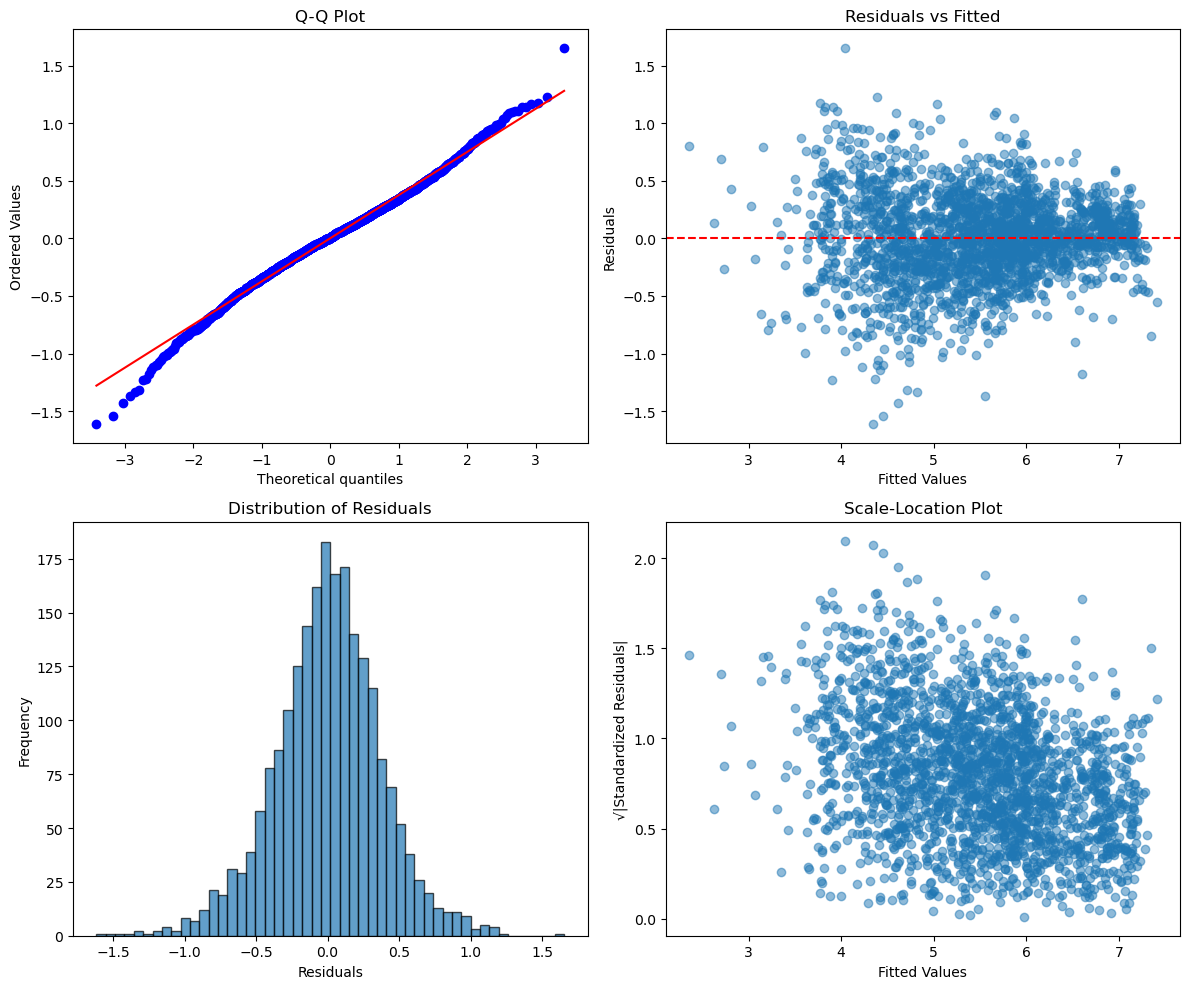

In [14]:
# RESIDUAL DIAGNOSTIC PLOTS
import matplotlib.pyplot as plt
from scipy import stats as sp_stats

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Q-Q Plot
sp_stats.probplot(final_model.resids, dist="norm", plot=axes[0, 0])
axes[0, 0].set_title("Q-Q Plot")

# 2. Residuals vs Fitted
axes[0, 1].scatter(final_model.fitted_values, final_model.resids, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel("Fitted Values")
axes[0, 1].set_ylabel("Residuals")
axes[0, 1].set_title("Residuals vs Fitted")

# 3. Histogram of residuals
axes[1, 0].hist(final_model.resids, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel("Residuals")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].set_title("Distribution of Residuals")

# 4. Scale-Location plot
standardized_resids = final_model.resids / final_model.resids.std()
axes[1, 1].scatter(final_model.fitted_values, np.sqrt(np.abs(standardized_resids)), alpha=0.5)
axes[1, 1].set_xlabel("Fitted Values")
axes[1, 1].set_ylabel("√|Standardized Residuals|")
axes[1, 1].set_title("Scale-Location Plot")

plt.tight_layout()
plt.show()

In [15]:
from sklearn.linear_model import LinearRegression
def wooldridge_test(model, y_data):
    """
    Wooldridge (2002) test for autocorrelation in panel data
    H0: No first-order autocorrelation
    H1: First-order autocorrelation present
    """
    
    # Get residuals
    resids = model.resids
    
    # Create DataFrame with residuals
    resid_df = pd.DataFrame({
        'resid': resids,
        'entity': resids.index.get_level_values(0),
        'time': resids.index.get_level_values(1)
    })
    
    # Sort by entity and time
    resid_df = resid_df.sort_values(['entity', 'time'])
    
    # Calculate first difference of residuals within each entity
    resid_df['resid_lag'] = resid_df.groupby('entity')['resid'].shift(1)
    resid_df['resid_diff'] = resid_df['resid'] - resid_df['resid_lag']
    
    # Drop NaN values
    resid_df = resid_df.dropna()
    
    # Regression: resid_diff on resid_lag
    X_test = resid_df['resid_lag'].values.reshape(-1, 1)
    y_test = resid_df['resid_diff'].values
    
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X_test, y_test)
    
    # Calculate F-statistic
    y_pred = reg.predict(X_test)
    ssr = np.sum((y_test - y_pred)**2)
    sst = np.sum(y_test**2)
    r2 = 1 - (ssr / sst)
    
    n = len(y_test)
    k = 1
    
    f_stat = (r2 / k) / ((1 - r2) / (n - k - 1))
    p_value = 1 - stats.f.cdf(f_stat, k, n - k - 1)
    
    return f_stat, p_value

In [16]:

def durbin_watson_panel(residuals):
    """
    Durbin-Watson statistic for panel data
    DW ≈ 2: no autocorrelation
    DW < 2: positive autocorrelation
    DW > 2: negative autocorrelation
    """
    import pandas as pd
    
    # Sort residuals
    resid_df = pd.DataFrame({
        'resid': residuals,
        'entity': residuals.index.get_level_values(0),
        'time': residuals.index.get_level_values(1)
    }).sort_values(['entity', 'time'])
    
    # Calculate lagged residuals within each entity
    resid_df['resid_lag'] = resid_df.groupby('entity')['resid'].shift(1)
    resid_df = resid_df.dropna()
    
    # Calculate DW statistic
    diff_squared = (resid_df['resid'] - resid_df['resid_lag'])**2
    resid_squared = resid_df['resid']**2
    
    dw_stat = diff_squared.sum() / resid_squared.sum()
    
    return dw_stat

AUTOCORRELATION TESTS FOR PANEL DATA

1. WOOLDRIDGE TEST (Best for Panel Data)
----------------------------------------------------------------------
F-statistic: 694.1251
p-value: 0.0000
Result: ⚠️  REJECT H0 - Autocorrelation is present
        Your clustered SEs help address this issue

2. DURBIN-WATSON TEST
----------------------------------------------------------------------
DW Statistic: 1.0131
Interpretation: ⚠️  DW < 2 - Positive autocorrelation likely

Note: DW test is less reliable for panel data than Wooldridge test

3. VISUAL INSPECTION
----------------------------------------------------------------------


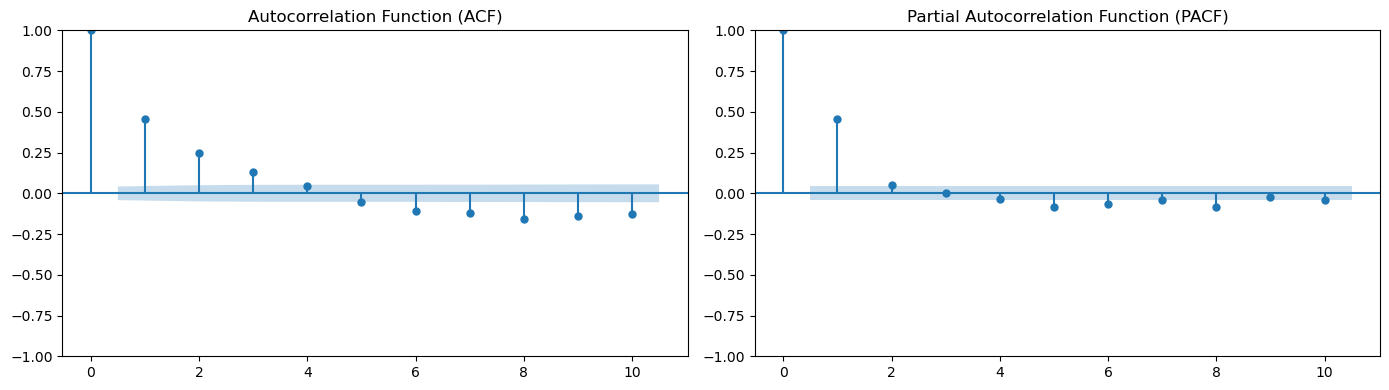


SUMMARY & RECOMMENDATIONS
⚠️  Autocorrelation detected (Wooldridge test p < 0.05)

✅ Good news: You're already using clustered standard errors!
   This helps address autocorrelation issues.

Additional options if needed:
  - Include lagged dependent variable
  - Use AR(1) panel model
  - Add time trends


In [17]:

print("="*70)
print("AUTOCORRELATION TESTS FOR PANEL DATA")
print("="*70)

# 1. Wooldridge Test (RECOMMENDED)
print("\n1. WOOLDRIDGE TEST (Best for Panel Data)")
print("-"*70)
f_stat, p_value = wooldridge_test(final_model, y)
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Result: ⚠️  REJECT H0 - Autocorrelation is present")
    print("        Your clustered SEs help address this issue")
else:
    print("Result: ✅ FAIL TO REJECT H0 - No significant autocorrelation")

# 2. Durbin-Watson Test
print("\n2. DURBIN-WATSON TEST")
print("-"*70)
dw_stat = durbin_watson_panel(final_model.resids)
print(f"DW Statistic: {dw_stat:.4f}")

if 1.5 < dw_stat < 2.5:
    print("Interpretation: ✅ DW ≈ 2 - No autocorrelation")
elif dw_stat < 1.5:
    print("Interpretation: ⚠️  DW < 2 - Positive autocorrelation likely")
else:
    print("Interpretation: ⚠️  DW > 2 - Negative autocorrelation likely")

print("\nNote: DW test is less reliable for panel data than Wooldridge test")

# 3. Visual Inspection (OPTIONAL)
print("\n3. VISUAL INSPECTION")
print("-"*70)

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# ACF plot
plot_acf(final_model.resids, lags=10, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(final_model.resids, lags=10, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

# Summary
print("\n" + "="*70)
print("SUMMARY & RECOMMENDATIONS")
print("="*70)

if p_value < 0.05:
    print("⚠️  Autocorrelation detected (Wooldridge test p < 0.05)")
    print("\n✅ Good news: You're already using clustered standard errors!")
    print("   This helps address autocorrelation issues.")
    print("\nAdditional options if needed:")
    print("  - Include lagged dependent variable")
    print("  - Use AR(1) panel model")
    print("  - Add time trends")
else:
    print("✅ No significant autocorrelation detected")
    print("   Your model specification is appropriate")
    print("   Clustered SEs provide additional robustness")

print("="*70)
